In [56]:
%matplotlib notebook
from metadatastore.mds import MDS
from databroker import Broker
from databroker.core import register_builtin_handlers
from filestore.fs import FileStore as FS
from pymongo import MongoClient
import datetime
import numpy as np
import os
import pytz
import matplotlib.pyplot as plt

utc=pytz.UTC

_mds_config = {'host': 'xf03id-ca1',
               'port': 27017,
               'database': 'datastore',
               'timezone': 'US/Eastern'}
mds = MDS(_mds_config, auth=False)

_fs_config = {'host': 'xf03id-ca1',
              'port': 27017,
              'database': 'filestore'}

db = Broker(mds, FS(_fs_config))

mds = MDS(_mds_config)
fs = FS(_fs_config)
conn = MongoClient(host=_fs_config['host'],
                  port=_fs_config['port'])
fsdb = conn.filestore

In [49]:
# 1. Copy database and perform the following on copied database
# 2. Fetch uids of resources with datums that have no resource info
# 3. Looking at the resources, get the file timestamps
# 4. Comparing consecutive resource timestamps and verifying against file timestamps, update datums' "resource" field
# 5. Verify and perform the same opeation on production db



In [ ]:
#Not possible via filestore, so resorting to pymongo for this limited purpose
incomplete_datums = list(fsdb.datum.find({'resource': None}))

In [50]:
patient_zero = next(mds.find_run_starts(scan_id=27768))
patient_last = next(mds.find_run_starts(scan_id=27917))
problem_starts = list(mds.find_run_starts(scan_id={'$gte': 27768, '$lte':27917}))

rstart_times = [r['time'] for r in problem_starts]

In [57]:
# find resources within defined time window 
end = np.max(rstart_times)
start = np.min(rstart_times)
end_utc = utc.localize(datetime.datetime.utcfromtimestamp(end))
start_utc = utc.localize(datetime.datetime.utcfromtimestamp(start))

query = fsdb.resource.find()
rlist = []
flist = []
for r in query:
    if start_utc<= r['_id'].generation_time <= end_utc:
        rlist.append(r)
        flist.append(os.path.getmtime(r['root'] + '/' +  r['resource_path']))
        

In [59]:
rlist[113]

{'_id': ObjectId('5924a149e97f4e149480acf2'),
 'resource_kwargs': {},
 'resource_path': '2017/05/23/d51a9a88-d5ab-497c-98b0_000000.h5',
 'root': '/data',
 'spec': 'XSP3',
 'uid': '1b1c027b-6ea3-451f-89c2-5a53182a25cb'}

In [60]:
hdr = db[27823]
t1 = hdr.start.time
t2 = hdr.stop.time

In [61]:
for des in hdr.descriptors:
    for k,v in des['data_keys'].items():
        if 'external' in v:
            print(k)

merlin1
xspress3_ch1
xspress3_ch2
xspress3_ch3


In [42]:
e = list(db.get_events(hdr, fill=False))

In [43]:
e[0].data

{'Det1_Ca': 0.0,
 'Det1_Cl': 1.0013660354392226,
 'Det1_Cr': 1.0013660354392226,
 'Det1_Cu': 0.0,
 'Det1_Fe': 0.0,
 'Det1_Ga': 0.0,
 'Det1_K': 1.0013660354392226,
 'Det1_Mn': 0.0,
 'Det1_Ni': 0.0,
 'Det1_P': 11.015026389831448,
 'Det1_S': 1.0013660354392226,
 'Det1_Se': 0.0,
 'Det1_Si': 312.4262030570374,
 'Det1_Te': 0.0,
 'Det1_Ti': 0.0,
 'Det1_Zn': 0.0,
 'Det2_Ca': 1.001693832323967,
 'Det2_Cl': 1.001693832323967,
 'Det2_Cr': 0.0,
 'Det2_Cu': 0.0,
 'Det2_Fe': 0.0,
 'Det2_Ga': 0.0,
 'Det2_K': 1.001693832323967,
 'Det2_Mn': 0.0,
 'Det2_Ni': 0.0,
 'Det2_P': 30.050814969719003,
 'Det2_S': 1.001693832323967,
 'Det2_Se': 0.0,
 'Det2_Si': 434.73512322860176,
 'Det2_Te': 1.001693832323967,
 'Det2_Ti': 1.001693832323967,
 'Det2_Zn': 1.001693832323967,
 'Det3_Ca': 1.0016033568214224,
 'Det3_Cl': 0.0,
 'Det3_Cr': 0.0,
 'Det3_Cu': 0.0,
 'Det3_Fe': 1.0016033568214224,
 'Det3_Ga': 0.0,
 'Det3_K': 0.0,
 'Det3_Mn': 0.0,
 'Det3_Ni': 0.0,
 'Det3_P': 26.041687277356985,
 'Det3_S': 0.0,
 'Det3_Se': 0.0,

In [44]:
dat = next(fsdb.datum.find({'datum_id': '67c0dbde-9aa8-4cf6-9829-02f134ac4b4f'}))

In [45]:
dat['resource'] = rlist[113]['uid']

In [46]:
dat

{'_id': ObjectId('5924a20ee97f4e149480acf3'),
 'datum_id': '67c0dbde-9aa8-4cf6-9829-02f134ac4b4f',
 'datum_kwargs': {'channel': 1, 'frame': 0},
 'resource': '1b1c027b-6ea3-451f-89c2-5a53182a25cb'}

<IPython.core.display.Javascript object>


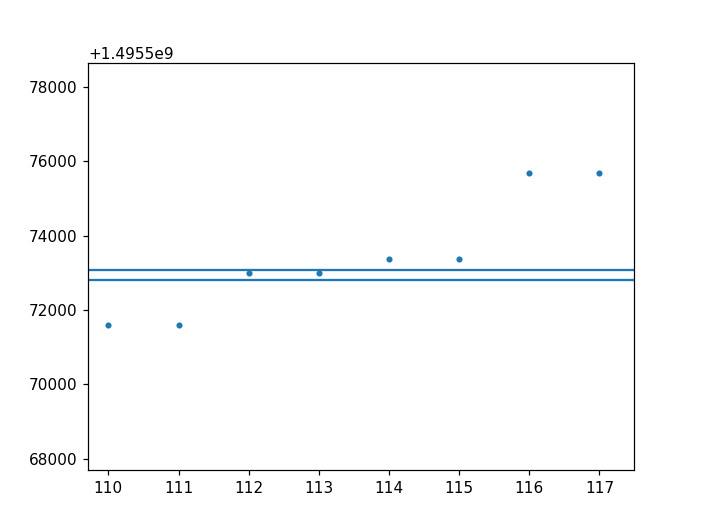

In [47]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot(flist, '.')
ax.axhline(t1)
ax.axhline(t2)

In [5]:
file_start_time = os.path.getmtime(rlist[0]['root'] + '/' +  rlist[0]['resource_path'])
file_end_time = os.path.getmtime(rlist[-1]['root'] + '/' +  rlist[-1]['resource_path'])

In [ ]:
for i in range(len(problem_resources)):
    primary = missing[i]
    try:
        secondary = missing[i+1]
    except IndexError:
        break
    diff = s_time - p_time
    fsdb.datum.find({'time': {'$gte': p_time, '$lt': s_time }})
    

In [ ]:
a = next(fsdb.resource.find())['_id']

In [ ]:
a.generation_time